In [9]:
import numpy as np
import h5py
import glob
from PIL import Image
import matplotlib.pyplot as plt

In [10]:
h5_path = '../Datasets/training/images_four_rotations_80_ratio.h5'
groundtruth_images_path = '../Datasets/training/groundtruth'
satelite_images_path = '../Datasets/training/images'

In [11]:
def add_to_h5(h5file, name_of_group, group, convertion):
    for i in range(len(group)):
        
        img = group[i]
        img = img.convert(convertion)
        img = np.array(img)
        
        h5file[name_of_group][i, ...] = img[None]

In [12]:
from scipy.ndimage import rotate

def append_four_rotation(list_of_images):
    new_images = []
    
    for image in list_of_images:
        for r in range(4):
            rotation = r * 90
            new_images.append(Image.fromarray(rotate(image, rotation)))
            
    return new_images

def append_mirror(list_of_images):
    new_images = []
    
    for image in list_of_images:
        new_images.append(Image.fromarray(np.flipud(image)))
        new_images.append(image)
            
    return new_images

def append_eight_rotation(list_of_images, bw=False):
    new_images = []
    
    for image in list_of_images:
        for r in range(4):
            rotation = r * 90
            new_images.append(Image.fromarray(rotate(image, rotation)))
        for r in range(4):

            s = (image.size[0], image.size[1])
            new_size = np.sqrt(2)*np.array(s) + 1
            new_size = new_size.astype(np.int)
            rotation = r * 90 + 45
            image_rot = np.array(image.resize(list(new_size)))
            image_rot = rotate(image_rot, rotation, reshape=True)
            if not bw:
                lx, ly, _ = image_rot.shape
                crop_image = image_rot[lx // 4: - lx // 4, ly // 4: - ly // 4, :]
            else:
                lx, ly = image_rot.shape
                crop_image = image_rot[lx // 4: - lx // 4, ly // 4: - ly // 4]
            
            new_images.append(Image.fromarray(crop_image))
                   
    return new_images        

In [13]:
from sklearn.utils import shuffle

satelite_images = list(map(Image.open, glob.glob(satelite_images_path + '/*.png')))
groundtruth_images =list(map(Image.open, glob.glob(groundtruth_images_path + '/*.png')))

satelite_images, groundtruth_images = shuffle(satelite_images, groundtruth_images)

train_test_ratio = 0.80

train_images = satelite_images[0:int(train_test_ratio*len(satelite_images))]
train_groundtruth = groundtruth_images[0:int(train_test_ratio*len(groundtruth_images))]

# add rotations
train_images = append_four_rotation(train_images)
train_groundtruth = append_four_rotation(train_groundtruth)

test_images = satelite_images[int(train_test_ratio*len(satelite_images)):]
test_groundtruth = groundtruth_images[int(train_test_ratio*len(groundtruth_images)):]

train_shape = (len(train_images), 400, 400, 3)
train_groundtruth_shape = (len(train_images), 400, 400)

test_shape = (len(test_images), 400, 400, 3)
test_groundtruth_shape = (len(test_images), 400, 400)

OSError: [Errno 24] Too many open files: '../Datasets/training/groundtruth/satImage_088.png'

In [8]:
with h5py.File(h5_path, mode='w') as h5file:
    
    h5file.create_dataset("train", train_shape, np.uint8)
    h5file.create_dataset("train_groundtruth", train_groundtruth_shape, np.uint8)

    h5file.create_dataset("test", test_shape, np.uint8)
    h5file.create_dataset("test_groundtruth", test_groundtruth_shape, np.uint8)
    
    add_to_h5(h5file, 'train', train_images, 'RGB')
    add_to_h5(h5file, 'train_groundtruth', train_groundtruth, 'L')
    add_to_h5(h5file, 'test', test_images, 'RGB')
    add_to_h5(h5file, 'test_groundtruth', test_groundtruth, 'L')

OSError: Unable to create file (unable to open file: name = 'training/images_four_rotations_80_ratio.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602)

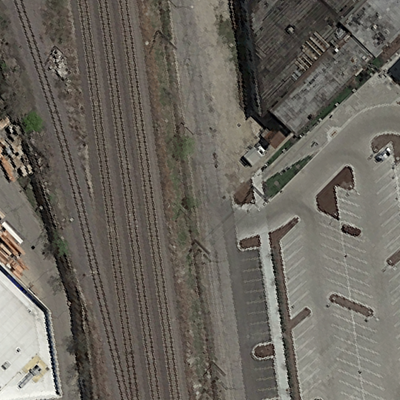

In [214]:
with h5py.File(h5_path, mode='r') as h5file:

    train = h5file['train'][5,...]
    groundtruth = h5file['train_groundtruth'][5,...]


train = train.astype("uint8")
groundtruth = groundtruth.astype("uint8")

train = Image.fromarray(train)
groundtruth = Image.fromarray(groundtruth)

train





In [194]:
new_size = np.sqrt(2)*np.array((train.size[0], train.size[1])) + 1
new_size = new_size.astype(np.int)
list(new_size)


[566, 566]

(800, 800, 3)


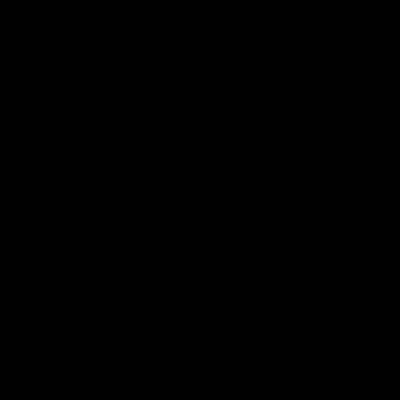

In [195]:
# Get percentage of positives compared to negatives
rotation = 45
train = np.array(train.resize(list(new_size)))
train = rotate(train, rotation, reshape=True)
lx, ly, _ = train.shape
print( train.shape)
# Cropping
crop_train = train[lx // 4: - lx // 4, ly // 4: - ly // 4, :]
Image.fromarray(crop_train)

In [33]:

size_positives = 0
size_total = 0
for i in range(len(groundtruth_images)):
    
    img = groundtruth_images[i]
 
    img = img.convert('L')
    img = np.array(img)
    img = img > 10
    
    size_positives = size_positives + img.sum()
    size_total = size_total + img.shape[0]*img.shape[1]
        
size_positives/size_total

0.2093884375